<b>Content</b>
<ul>
<li>Read Data in</li>
<li>Fetch Audio Features for Tracks from Spotify Web API</li>
<li>Split Data into Train-Valid-Test sets</li>
<li>Preprocess Data for Train-Valid sets</li>
<li>Build Models with Random Forests & Neural Networks</li>
<li>Test out Models on Test set</li>
</ul>

# Prediction on Streams of Spotify's Daily Most Listened Songs

<b>Goal: </b>
Build machine learning models to predict 'Streams' of Spotify's worldwide daily most listened songs.<br>
<b>Dataset: </b>
The daily 200 most listened songs in 53 countries from 2017 to 2018 by Spotify users. More descriptions can be found <a href='https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking'>Here</a>.<br>
<b>Basic Ideas: </b>
Explore & Preprocess data -> Build a random forests model for prediction with variable importance analysis -> Build a deep neural networks model for prediction<br>
<b>Measurements to evaluate models: </b>
R-Squared, Mean Squared Error<br>

In [1]:
"""Import necessary packages"""

import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


## &#8544;. Read Data in

In [2]:
%pwd

'/Users/gao.xiaob/Desktop/spotify'

In [3]:
# Current path
c_path = '/Users/gao.xiaob/Desktop/spotify'

In [4]:
df_data = pd.read_csv(f'{c_path}/data.csv', parse_dates=['Date'])

print(df_data.shape)
df_data.head()

(3441197, 7)


,Position,Track Name,Artist,Streams,URL,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441197 entries, 0 to 3441196
Data columns (total 7 columns):
Position      int64
Track Name    object
Artist        object
Streams       int64
URL           object
Date          datetime64[ns]
Region        object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 183.8+ MB


<i>From the outputs, we know that we are going to deal with a giant dataset, which contains more than 3 million rows of data. Even with such a giant dataset, however, it might still be hard to build good machine learning models, since there are only 6 data features there and features like 'URL' have nothing to do with 'Streams'. As we all know, audio features of songs are what really matters when it comes to helping songs get popular and gain more streams. Therefore, instead of directly throwing 'URL' into our feature models, we should use 'URL' in a more meaningful way- to fetch audio features for tracks from Spotify Web API.</i>

## &#8545;.  Fetch Audio Features for Tracks from Spotify Web API

In [7]:
"""
In order to use Spotify API to fetch data, we need to set our Spotify API credentials, 
which means to register an app on Spotify website first. I have done that outside the 
notebook, so now we have gotten the needed environment variables, as below: 
    SPOTIPY_CLIENT_ID='9b89bceb41094be298505c3970a11bcc'
    SPOTIPY_CLIENT_SECRET='bbfd5570092b4e09b88e83e744f7e848'
    SPOTIPY_REDIRECT_URI='http://google.com/'
"""

"""
Spotify would give their users instant IDs when requested. Those IDs will be valid
for an hour. To request your instant ID: 
    go to Spotify player-> log in your Spotify account-> click on your profile image
    -> get an ID by clicking 'Copy Profile Link' under '...'
"""

# Here's my instant profile link: 
# https://open.spotify.com/user/31z2m2i3pqszfsroulu63g7bc3hu?si=ep-YkJQLR6qkcz5HfOc1iQ
user_id = '31z2m2i3pqszfsroulu63g7bc3hu?si=ep-YkJQLR6qkcz5HfOc1iQ'
token = util.prompt_for_user_token(user_id, 
                                   client_id='9b89bceb41094be298505c3970a11bcc', 
                                   client_secret='bbfd5570092b4e09b88e83e744f7e848',
                                   redirect_uri='http://google.com/')
spotify_obj = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9b89bceb41094be298505c3970a11bcc&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQDZgza7NajLEZFu3iE7h37U910XaH0N5I06zTF5gWHQaCXMsSS0P38vjc1gFPysd3G2bqDn5_Q78JWBp4WNxEtyg981YfDnG3YCRAOxLiKVsdXy3jYxHZiX8KRphgfGaezDYwSu3nEfktvboHS7HnNR2wgqMnp0iTp2o_NNBvbJzV7gbTDK__tU




In [8]:
"""Fetch audio features for a track with its url and have a
general picture of what audio features there are"""

# Get url of the first track
url = df_data['URL'][0]

# Fetch audio features of the first track
spotify_obj.audio_features(url)

[{'danceability': 0.761,
  'energy': 0.838,
  'key': 4,
  'loudness': -3.073,
  'mode': 0,
  'speechiness': 0.0502,
  'acousticness': 0.4,
  'instrumentalness': 0,
  'liveness': 0.176,
  'valence': 0.71,
  'tempo': 93.974,
  'type': 'audio_features',
  'id': '3AEZUABDXNtecAOSC1qTfo',
  'uri': 'spotify:track:3AEZUABDXNtecAOSC1qTfo',
  'track_href': 'https://api.spotify.com/v1/tracks/3AEZUABDXNtecAOSC1qTfo',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3AEZUABDXNtecAOSC1qTfo',
  'duration_ms': 222560,
  'time_signature': 4}]

<i>For more information on what these audio feature names stand for, check <a href='https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/'>this</a> out.</i>

In [9]:
# Check how many NaNs there are
df_data.isnull().sum()

Position        0
Track Name    657
Artist        657
Streams         0
URL             8
Date            0
Region          0
dtype: int64

<i>From the output, we know that there are 8 NaNs in the 'URL' column. If we try to use these NaNs as URLs to fetch data from Spotify, errors would be thrown. So we have to deal with NaNs for the 'URL' column first.</i>

In [10]:
# Replace NaNs with ''
df_data_2 = df_data.fillna(value={'URL': ''})

df_data_2.isnull().sum()

Position        0
Track Name    657
Artist        657
Streams         0
URL             0
Date            0
Region          0
dtype: int64

In [11]:
"""Fetch audio features for all tracks"""

audio_features = []
for i in range(0, len(df_data), 50):
    if i == 0:
        print("Fetching audio features...")
        print()
    while True:
        try:
            # Spotify API allows at most 50 tracks to fetch audio features at a time
            audio_features += spotify_obj.audio_features(df_data_2['URL'][i:i+50].values.tolist())
            if i % 300000 == 0 and i != 0:
                print(f"Done for {i} tracks!")
            break
        except:
            print()
            # Get user ID renewed when it's expired in a hour
            user_id = input("Enter new user ID to get access token refreshed: ")
            token = util.prompt_for_user_token(user_id, 
                                            client_id='9b89bceb41094be298505c3970a11bcc', 
                                            client_secret='bbfd5570092b4e09b88e83e744f7e848',
                                            redirect_uri='http://google.com/')
            spotify_obj = spotipy.Spotify(auth=token)
print()
print("Done for all tracks!")

Fetching audio features...

Done for 300000 tracks!
Done for 600000 tracks!
Done for 900000 tracks!
Done for 1200000 tracks!

Enter new user ID to get access token refreshed: 31z2m2i3pqszfsroulu63g7bc3hu?si=UZ7ZAHv8QQumHpKFKf_TkQ


            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9b89bceb41094be298505c3970a11bcc&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQAPSrBU6iwO8_gXf0K_-TkbK22lsX7Xdp3qifGX6nJFq3U7vc00fjFMnuYOdugUmU79-QoUf212sDDaLn9iGkbN7dR7vvz_TxMwVC2b-6WIJ4bGF9v0gdG3wN6GWCEnd7a6RL3s0bqCPanzPzcru8MmNw4rkIkF73HRoEZc62TzOSPztVYV4umW


Done for 1500000 tracks!
Done for 1800000 tracks!
Done fo

In [12]:
"""We got None objects in audio_feature when URLs were invalid. 
Those None objects would be big trouble if we constructed a DataFrame 
object with audio_feature directly. So replace them first"""

# Replace None objects in audio_features with {}
audio_features_2 = [{} if item is None else item for item in audio_features]

In [13]:
# Construct a DataFrame object with audio_feature_2
df_audio_features = pd.DataFrame(audio_features_2)

print(df_audio_features.shape)
df_audio_features.head()

(3441197, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.40000,https://api.spotify.com/v1/audio-analysis/3AEZ...,0.761,222560.0,0.838,3AEZUABDXNtecAOSC1qTfo,0.000000,4.0,0.176,-3.073,0.0,0.0502,93.974,4.0,https://api.spotify.com/v1/tracks/3AEZUABDXNte...,audio_features,spotify:track:3AEZUABDXNtecAOSC1qTfo,0.710
1,0.18700,https://api.spotify.com/v1/audio-analysis/6mIC...,0.852,195840.0,0.773,6mICuAdrwEjh6Y6lroV2Kg,0.000030,8.0,0.159,-2.921,0.0,0.0776,102.034,4.0,https://api.spotify.com/v1/tracks/6mICuAdrwEjh...,audio_features,spotify:track:6mICuAdrwEjh6Y6lroV2Kg,0.907
2,0.05590,https://api.spotify.com/v1/audio-analysis/3QwB...,0.832,209453.0,0.772,3QwBODjSEzelZyVjxPOHdq,0.000486,10.0,0.440,-5.429,1.0,0.1000,96.016,4.0,https://api.spotify.com/v1/tracks/3QwBODjSEzel...,audio_features,spotify:track:3QwBODjSEzelZyVjxPOHdq,0.704
3,0.00431,https://api.spotify.com/v1/audio-analysis/7DM4...,0.663,259196.0,0.920,7DM4BPaS7uofFul3ywMe46,0.000017,11.0,0.101,-4.070,0.0,0.2260,99.935,4.0,https://api.spotify.com/v1/tracks/7DM4BPaS7uof...,audio_features,spotify:track:7DM4BPaS7uofFul3ywMe46,0.533
4,0.55100,https://api.spotify.com/v1/audio-analysis/6rQS...,0.508,205600.0,0.687,6rQSrBHf7HlZjtcMZ4S4bO,0.000003,0.0,0.126,-4.361,1.0,0.3260,180.044,4.0,https://api.spotify.com/v1/tracks/6rQSrBHf7HlZ...,audio_features,spotify:track:6rQSrBHf7HlZjtcMZ4S4bO,0.555


In [14]:
# Save audio features as CSV to current path 
df_audio_features.to_csv(f'{c_path}/audio_features.csv')

## &#8546;. Split Data into Train-Valid-Test Sets

In [15]:
"""Integrate audio features into original dataset. We will be only using the 
integrated dataset from here throughout to the end"""

# df_af = df_audio_features.copy()
df_af = pd.read_csv(f'{c_path}/audio_features.csv', index_col=0)
df_data_with_af = pd.concat([df_data, df_af], axis=1)
df_data_with_af.sort_values(by=['Date', 'Region'], inplace=True)

print(df_data_with_af.shape)
df_data_with_af.head(3)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(3441197, 25)


,Position,Track Name,Artist,Streams,URL,Date,Region,acousticness,analysis_url,danceability,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
148400,1,Chantaje,Shakira,253019,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ar,0.18700,https://api.spotify.com/v1/audio-analysis/6mIC...,0.852,...,0.159,-2.921,0.0,0.0776,102.034,4.0,https://api.spotify.com/v1/tracks/6mICuAdrwEjh...,audio_features,spotify:track:6mICuAdrwEjh6Y6lroV2Kg,0.907
148401,2,Vente Pa' Ca,Ricky Martin,223988,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ar,0.00431,https://api.spotify.com/v1/audio-analysis/7DM4...,0.663,...,0.101,-4.070,0.0,0.2260,99.935,4.0,https://api.spotify.com/v1/tracks/7DM4BPaS7uof...,audio_features,spotify:track:7DM4BPaS7uofFul3ywMe46,0.533
148402,3,Reggaetón Lento (Bailemos),CNCO,210943,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ar,0.40000,https://api.spotify.com/v1/audio-analysis/3AEZ...,0.761,...,0.176,-3.073,0.0,0.0502,93.974,4.0,https://api.spotify.com/v1/tracks/3AEZUABDXNte...,audio_features,spotify:track:3AEZUABDXNtecAOSC1qTfo,0.710


In [16]:
"""Seperate out X and y"""

y_data_with_af = df_data_with_af['Streams']
X_data_with_af = df_data_with_af.drop(['Streams'], axis=1)

print(X_data_with_af.shape, y_data_with_af.shape)

(3441197, 24) (3441197,)


In [17]:
"""Split data into training set, validation set, and test set"""

(X_train_valid, X_test, y_train_valid, y_test) = train_test_split(X_data_with_af, y_data_with_af, 
                                                            test_size=0.12, shuffle=False)

print('Shape:')
print('Train-Valid Set -', X_train_valid.shape, y_train_valid.shape)
print('Test Set -', X_test.shape, y_test.shape)

Shape:
Train-Valid Set - (3028253, 24) (3028253,)
Test Set - (412944, 24) (412944,)


## &#8547;. Preprocess Data for Train-Valid Sets

In [18]:
"""Define some functions for data preprocessing for later use"""

def split_date(df, date_column):
    """Function to split df[date_column] into four other date relevant columns
       df: a DataFrame object
       data_column: name of the column with datetime64 dtype - str
    """
    df = df.copy()
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
                            "month": df[date_column].dt.month,
                            "day": df[date_column].dt.day,
                            "dayofweek": df[date_column].dt.dayofweek,
             })
    df = df.drop(date_column, axis=1)
    df = pd.concat([df, date_df], axis=1)
    return df

def convert_cat_to_num(df, feature, mapping):
    """Function to convert data with object type to numerical values
       df: a DateFrame object
       feature: a feature of the df - str
       mapping: categories and their mapping values - None/dict 
    """
    df = df.copy()
    cats_list = df[feature].astype('category').cat.categories.tolist()
    if mapping is None:
        mapping = {k: v for k, v in zip(cats_list, list(range(1, len(cats_list) + 1)))}
        
    else:
        new_cats_list = []
        for c in cats_list:
            if c not in mapping:
                new_cats_list.append(c)
        start = len(mapping) + 1
        mapping.update({k: v for k, v in zip(new_cats_list, list(range(start, len(new_cats_list) + start)))})
                                    
    df[feature] = df[feature].map(mapping)
    return df, mapping

In [19]:
"""Throw away columns that intuitively have nothing to do with streams. We also throw 
the 'Position' column since tracks' ranking is based on their streams and we will never 
know this information until we got streams"""

X_train_valid_2 = X_train_valid.drop(['Position', 'URL', 'analysis_url', 'id', 'track_href', 'type', 'uri'], axis=1)

In [20]:
"""Split 'Data' column"""

X_train_valid_3 = split_date(X_train_valid_2, 'Date')

X_train_valid_3.tail(3)

,Track Name,Artist,Region,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,month,day,dayofweek
2325527,Despacito (Featuring Daddy Yankee),Luis Fonsi,pa,0.2090,0.660,228200.0,0.786,0.0,2.0,0.112,-4.757,1.0,0.170,177.833,4.0,0.846,2017,11,27,0
2325528,Mi Mala,Mau y Ricky,pa,0.0149,0.737,222731.0,0.624,0.0,5.0,0.145,-5.236,0.0,0.199,172.036,4.0,0.803,2017,11,27,0
2325529,Krippy Kush - Remix,Farruko,pa,0.0512,0.743,237160.0,0.671,0.0,9.0,0.116,-5.241,1.0,0.122,163.229,4.0,0.499,2017,11,27,0


In [21]:
X_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3028253 entries, 148400 to 2325529
Data columns (total 20 columns):
Track Name          object
Artist              object
Region              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
year                int64
month               int64
day                 int64
dayofweek           int64
dtypes: float64(13), int64(4), object(3)
memory usage: 485.2+ MB


In [22]:
"""Convert data with object type to numerical values"""

X_train_valid_4, track_name_map = convert_cat_to_num(X_train_valid_3, 'Track Name', None)
X_train_valid_4, artist_map = convert_cat_to_num(X_train_valid_4, 'Artist', None)
X_train_valid_4, region_map = convert_cat_to_num(X_train_valid_4, 'Region', None)

X_train_valid_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3028253 entries, 148400 to 2325529
Data columns (total 20 columns):
Track Name          float64
Artist              float64
Region              int64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
year                int64
month               int64
day                 int64
dayofweek           int64
dtypes: float64(15), int64(5)
memory usage: 485.2 MB


In [23]:
X_train_valid_4.isnull().sum()

Track Name          657
Artist              657
Region                0
acousticness         25
danceability         25
duration_ms          25
energy               25
instrumentalness     25
key                  25
liveness             25
loudness             25
mode                 25
speechiness          25
tempo                25
time_signature       25
valence              25
year                  0
month                 0
day                   0
dayofweek             0
dtype: int64

In [24]:
"""Deal with NaNs"""

X_train_valid_5 = X_train_valid_4.fillna(0)

In [25]:
"""Standardize continuous variables"""

# scaler = MinMaxScaler()
scaler = StandardScaler()

con_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
X_train_valid_5[con_cols] = scaler.fit_transform(X_train_valid_5[con_cols])

X_train_valid_5.head()
Xtrain_valid_stats = X_train_valid_5.describe().transpose()
Xtrain_valid_stats

,count,mean,std,min,25%,50%,75%,max
Track Name,3028253.0,7.641966e+03,4358.462583,0.000000,3754.000000,7838.000000,11500.000000,16119.000000
Artist,3028253.0,2.664236e+03,1539.249073,0.000000,1367.000000,2618.000000,3978.000000,5738.000000
Region,3028253.0,2.684294e+01,15.985661,1.000000,13.000000,26.000000,41.000000,54.000000
acousticness,3028253.0,-1.527072e-14,1.000000,-0.961844,-0.744948,-0.369057,0.421327,3.605836
danceability,3028253.0,-8.485440e-14,1.000000,-5.367038,-0.553306,0.126465,0.663959,2.402910
duration_ms,3028253.0,1.496518e-13,1.000000,-5.707527,-0.608386,-0.132884,0.438018,96.144200
energy,3028253.0,-5.701961e-15,1.000000,-4.181906,-0.665476,0.118719,0.790886,2.035640
instrumentalness,3028253.0,5.699572e-13,1.000000,-0.126273,-0.126273,-0.126273,-0.126011,18.488081
key,3028253.0,1.864665e-14,1.000000,-1.404782,-1.133713,-0.049438,0.763768,1.576974
liveness,3028253.0,-2.078880e-14,1.000000,-1.387101,-0.598223,-0.361814,0.197433,7.027030


In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid_5, y_train_valid, 
                                                    train_size=0.85, shuffle=False)

print('Shape:')
print('Train Set -', X_train.shape, y_train.shape)
print('Validation Set -', X_valid.shape, y_valid.shape)

Shape:
Train Set - (2574015, 20) (2574015,)
Validation Set - (454238, 20) (454238,)


## &#8548;. Build Models with Random Forests & Neural Networks

### - Random Forests Model

In [27]:
"""Build a random forests model"""

rf_model = RandomForestRegressor(n_jobs=-1, max_features='auto', n_estimators=50)
rf_model.fit(X_train, y_train)

print('R_Squared:', rf_model.score(X_valid, y_valid))

R_Squared: 0.8766494154520825


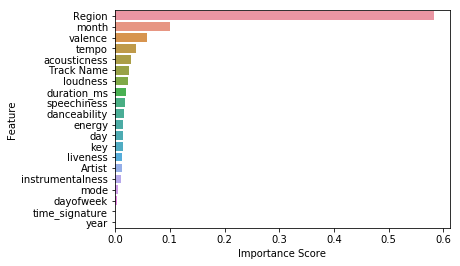

In [28]:
'''Plot feature importance scores of variables'''

rf_model.feature_importances_
feat_imps = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns,
            columns=['Importance score']).sort_values('Importance score', ascending=False)

feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature", "Importance Score"]
sns.barplot(x="Importance Score", y="Feature", data=feat_imps, orient="h")

In [29]:
"""Throw those columns with little importance"""

X_train_final = X_train.drop(['year', 'time_signature', 'dayofweek', 'mode'], axis=1)
X_valid_final = X_valid.drop(['year', 'time_signature', 'dayofweek', 'mode'], axis=1)

print(X_train_final.shape, X_valid_final.shape)

(2574015, 16) (454238, 16)


In [31]:
"""Retrain the random forests model with ultimate training dataset"""

# rf_model_final = RandomForestRegressor(n_jobs=-1, max_features='auto', n_estimators=50)
rf_model.fit(X_train_final, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

### - Neural Networks Model

In [32]:
"""Build a deep neural networks model"""

dnn_model = Sequential()
dnn_model.add(Dense(20, input_dim=16, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(18, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(13, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(9, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(1, kernel_initializer='normal'))

dnn_model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
history = dnn_model.fit(X_train_final, y_train, validation_data=(X_valid_final, y_valid), 
                        nb_epoch=100, batch_size=30000)

W0804 20:29:39.557233 4469200320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 20:29:39.774284 4469200320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 20:29:39.797087 4469200320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0804 20:29:39.879382 4469200320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: 

Train on 2574015 samples, validate on 454238 samples
Epoch 1/100
2574015/2574015 [==============================] - 3s 1us/step - loss: 44434112661.2310 - mean_squared_error: 44434112661.2310 - val_loss: 40744611877.8546 - val_mean_squared_error: 40744611877.8546
Epoch 2/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 42985047128.8834 - mean_squared_error: 42985047128.8834 - val_loss: 38611922161.4247 - val_mean_squared_error: 38611922161.4247
Epoch 3/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 42255909580.5571 - mean_squared_error: 42255909580.5571 - val_loss: 38573007775.9522 - val_mean_squared_error: 38573007775.9522
Epoch 4/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 42229653452.3468 - mean_squared_error: 42229653452.3468 - val_loss: 38549132723.0712 - val_mean_squared_error: 38549132723.0712
Epoch 5/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 42211600188.7370 - m

2574015/2574015 [==============================] - 2s 1us/step - loss: 41872605261.7424 - mean_squared_error: 41872605261.7424 - val_loss: 38333112216.2470 - val_mean_squared_error: 38333112216.2470
Epoch 40/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41865827281.8308 - mean_squared_error: 41865827281.8308 - val_loss: 38311927672.0372 - val_mean_squared_error: 38311927672.0372
Epoch 41/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41861987694.9968 - mean_squared_error: 41861987694.9968 - val_loss: 38328310146.3642 - val_mean_squared_error: 38328310146.3642
Epoch 42/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41854165331.6605 - mean_squared_error: 41854165331.6605 - val_loss: 38278204966.8262 - val_mean_squared_error: 38278204966.8262
Epoch 43/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41848662690.2846 - mean_squared_error: 41848662690.2846 - val_loss: 38290628334.7

Epoch 78/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41705437463.7127 - mean_squared_error: 41705437463.7127 - val_loss: 38269470942.2313 - val_mean_squared_error: 38269470942.2313
Epoch 79/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41703258917.4346 - mean_squared_error: 41703258917.4346 - val_loss: 38250358929.8007 - val_mean_squared_error: 38250358929.8007
Epoch 80/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41703007327.7578 - mean_squared_error: 41703007327.7578 - val_loss: 38209287264.9405 - val_mean_squared_error: 38209287264.9405
Epoch 81/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41699382485.4574 - mean_squared_error: 41699382485.4574 - val_loss: 38343068199.5972 - val_mean_squared_error: 38343068199.5972
Epoch 82/100
2574015/2574015 [==============================] - 2s 1us/step - loss: 41706680316.8970 - mean_squared_error: 41706680316.8970 - val_loss: 

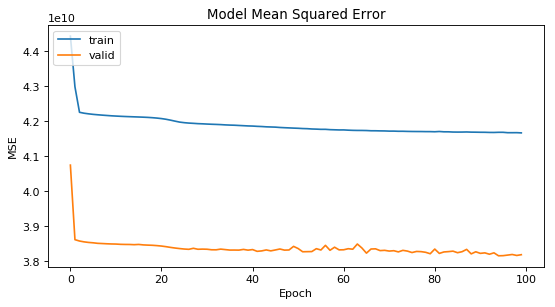

In [33]:
"""Plot epoch vs training set mse & epoch vs validation set mse"""

plt.figure(figsize=(8, 4), dpi=80)
# axes = plt.gca()
# axes.set_ylim([0.60, 0.85])
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
print('Mean_Squared_Error on training set:', history.history['mean_squared_error'][-1])
print('Mean_Squared_Error on validation set:', history.history['val_mean_squared_error'][-1])

Mean_Squared_Error on training set: 41666871554.83896
Mean_Squared_Error on validation set: 38181866555.11291


## &#8549;. Test out Models on Test Set

In [35]:
print(X_test.shape)
X_test.head()

(412944, 24)


,Position,Track Name,Artist,URL,Date,Region,acousticness,analysis_url,danceability,duration_ms,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
2325530,73,Friends (with BloodPop®),Justin Bieber,https://open.spotify.com/track/7nZmah2llfvLDiU...,2017-11-27,pa,0.00459,https://api.spotify.com/v1/audio-analysis/7nZm...,0.744,189467.0,...,0.3060,-5.350,1.0,0.0387,104.990,4.0,https://api.spotify.com/v1/tracks/7nZmah2llfvL...,audio_features,spotify:track:7nZmah2llfvLDiUjm0kiyz,0.649
2325531,74,Dile Que Tu Me Quieres,Ozuna,https://open.spotify.com/track/5u5MvmVtitax9R1...,2017-11-27,pa,0.08640,https://api.spotify.com/v1/audio-analysis/5u5M...,0.773,226520.0,...,0.0727,-4.959,1.0,0.0526,88.006,4.0,https://api.spotify.com/v1/tracks/5u5MvmVtitax...,audio_features,spotify:track:5u5MvmVtitax9R1Mxh3reC,0.858
2325532,75,XO TOUR Llif3,Lil Uzi Vert,https://open.spotify.com/track/7GX5flRQZVHRAGd...,2017-11-27,pa,0.00264,https://api.spotify.com/v1/audio-analysis/7GX5...,0.732,182707.0,...,0.1090,-6.366,0.0,0.2310,155.096,4.0,https://api.spotify.com/v1/tracks/7GX5flRQZVHR...,audio_features,spotify:track:7GX5flRQZVHRAGd6B4TmDO,0.401
2325533,76,El Amante,Nicky Jam,https://open.spotify.com/track/3umS4y3uQDkqekN...,2017-11-27,pa,0.24300,https://api.spotify.com/v1/audio-analysis/3umS...,0.683,219507.0,...,0.1400,-5.535,1.0,0.0432,179.910,4.0,https://api.spotify.com/v1/tracks/3umS4y3uQDkq...,audio_features,spotify:track:3umS4y3uQDkqekNjVpiRUs,0.732
2325534,77,Attention,Charlie Puth,https://open.spotify.com/track/4iLqG9SeJSnt0cS...,2017-11-27,pa,0.09690,https://api.spotify.com/v1/audio-analysis/4iLq...,0.774,211475.0,...,0.0848,-4.432,0.0,0.0432,100.041,4.0,https://api.spotify.com/v1/tracks/4iLqG9SeJSnt...,audio_features,spotify:track:4iLqG9SeJSnt0cSPICSjxv,0.777


<i>Next, we should preprocess test set data exactly the same way we did for training set data and 
validation set data, except that we use those maps we got earlier when converting object type data to numerical values.</i>

In [36]:
"""Preprocess test set data"""

# Drop columns that intuitively wouldn't be helpful 
X_test_2 = X_test.drop(['Position', 'URL', 'analysis_url', 'id', 'track_href', 'type', 'uri'], axis=1)

# Split the 'Data' column
X_test_3 = split_date(X_test_2, 'Date')

# Convert object type data to numerical values with those maps we got earlier
X_test_4, _ = convert_cat_to_num(X_test_3, 'Track Name', track_name_map)
X_test_4, _ = convert_cat_to_num(X_test_4, 'Artist', artist_map)
X_test_4, _ = convert_cat_to_num(X_test_4, 'Region', region_map)

# Deal with NaNs
X_test_5 = X_test_4.fillna(0)

# Standardize continuous variables
X_test_5[con_cols] = scaler.transform(X_test_5[con_cols])

# Drop columns with little importance
X_test_final = X_test_5.drop(['year', 'time_signature', 'dayofweek', 'mode'], axis=1)

X_test_final.head()

,Track Name,Artist,Region,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,month,day
2325530,4304,2505,41,-0.940752,0.513777,-0.790390,0.417460,-0.126273,0.763768,1.205773,0.207072,-0.682596,-0.505124,0.569638,11,27
2325531,3004,3829,41,-0.564815,0.743002,0.171227,0.529488,-0.126203,-1.133713,-0.771082,0.389772,-0.530823,-1.106271,1.512973,11,27
2325532,14055,2928,41,-0.949713,0.418925,-0.965829,0.485921,-0.126273,1.576974,-0.463496,-0.267667,1.417117,1.268372,-0.549725,11,27
2325533,3449,3668,41,0.154802,0.031613,-0.010778,0.118719,-0.126273,0.763768,-0.200819,0.120628,-0.633461,2.146661,0.944264,11,27
2325534,952,896,41,-0.516564,0.750907,-0.219228,-0.285826,-0.125685,-0.591575,-0.668553,0.636019,-0.633461,-0.680293,1.147374,11,27


<i>Testing...</i>

In [37]:
print("R_Squared on test set with the Random Forests Model:")
print(rf_model.score(X_test_final, y_test))

R_Squared on test set with the Random Forests Model:
0.43085764361915024


In [38]:
print("Mean_Squared_Error on test set with the Neural Networks Model:") 
print(dnn_model.evaluate(X_test_final, y_test, batch_size=30000)[-1])

Mean_Squared_Error on test set with the Neural Networks Model:
412944/412944 [==============================] - 0s 1us/step
36778822936.311516
